<a href="https://colab.research.google.com/github/baigouy/notebooks/blob/master/minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <-- Press Run

# slow --> keep it as a separate step
# install python libraries necessary to run epyseg
# TODO check that all those libs are reallyu required but ok for now
!pip install czifile
!pip install h5py
!pip install Markdown
!pip install matplotlib
!pip install numpy
!pip install numpydoc
!pip install Pillow
!pip install PyQt5
!pip install PyQtWebEngine
!pip install read-lif
!pip install scikit-image
!pip install scipy
!pip install segmentation-models==1.0.1
!pip install tifffile==2021.11.2
!pip install qtawesome
!pip install natsort
!pip install numexpr
!pip install elasticdeform
!pip install roifile
!pip install prettytable
!pip install pyperclip
!pip install sklearn
!pip install --no-deps epyseg # prevent reinstalling tf 2.x and rather use the google optimized tf
# !pip install --no-deps --index-url https://test.pypi.org/simple/ epyseg


# libraries loaded checking epyseg to see if everything is functional
try:
  from epyseg.img import Img
  # just try import any class from Epyseg --> will raise an error if loading fails if loads most likely everything should work
  from epyseg.deeplearning.deepl import EZDeepLearning
  from epyseg.deeplearning.augmentation.meta import MetaAugmenter
  from epyseg.deeplearning.augmentation.generators.data import DataGenerator
  deepTA = EZDeepLearning()
  print('EPySeg succesfully loaded, please move on to next step!') 
except:
  print('EPySeg failed to load. Please repeat this step.')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 KB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.3 MB/s eta 0:00:00
  Atte

Using tensorflow version 2.9.2
Using segmentation models version 1.0.1


INFO - 2023-02-06 20:34:59,397 - deepl.py - load_weights - line 840 - Loading weights ' /root/.keras/epyseg/Linknet-vgg16-sigmoid-v2.h5'

INFO:master:Loading weights ' /root/.keras/epyseg/Linknet-vgg16-sigmoid-v2.h5'


9/9 [==============================] - 9s 912ms/step


INFO - 2023-02-06 20:35:10,629 - deepl.py - get_HQ_predictions - line 1994 - HQ predictions

INFO:master:HQ predictions


9/9 [==============================] - 7s 731ms/step
post processing/refining mask, please wait...


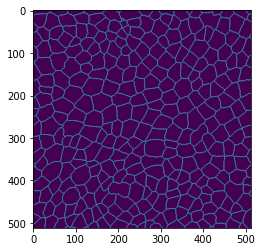

In [3]:
import traceback

import matplotlib.pyplot as plt

from epyseg.deeplearning.callbacks.stop import myStopCallback
from epyseg.deeplearning.deepl import EZDeepLearning
import os
import numpy as np

from epyseg.img import Img
from epyseg.postprocess.filtermask import simpleFilter

def predict_single_image(deepTA, single_image_predict_generator,predict_parameters, batch_size=1):
                         # progress_callback=None,
                   # hq_predictions='mean', post_process_algorithm=None, hq_pred_options='all',
                   # **kwargs):

    input_shape = deepTA.get_inputs_shape()
    output_shape = deepTA.get_outputs_shape()

    predict_generator = deepTA.get_predict_generator(
        inputs=[single_image_predict_generator], input_shape=input_shape,
        output_shape=output_shape,
        z_frames_to_add=None,
        clip_by_frequency=None, **predict_parameters)  # before was 0.05 which is bad especially with restored images

    results = None
    image, crop_parameters = next(predict_generator.predict_generator())
    try:
        results = deepTA.model.predict(image, verbose=1, batch_size=batch_size)
        if predict_parameters["hq_pred_options"] is not None:
            # TODO fix the line below to handle several outputs support --> TODO (do that in a smart way)
            results = deepTA.get_HQ_predictions(image, results, batch_size=batch_size,
                                              projection_method=predict_parameters["hq_pred_options"],
                                              hq_pred_options= predict_parameters["hq_pred_options"] )
    except:
        traceback.print_exc()
        print('Could not predict output for cur image')

    if results is None:
        print('Prediction interrupted or failed. Stopping...')
        return

    if isinstance(results, np.ndarray):  # convert to list if single output
        results = [results]


    # need rempve the loops in single since only one image and one data --> redo the code
    final_output = []
    for cur_count, result in enumerate(results):
        for j in range(len(crop_parameters)):
            # cur_output_shape = output_shape[cur_count]
            ordered_tiles = Img.linear_to_2D_tiles(result, crop_parameters[j])

            # 2D image
            # if len(cur_output_shape) == 4:
            reconstructed_tile = Img.reassemble_tiles(ordered_tiles, crop_parameters[j])
            # run post process directly on the image if available
            # if cur_output_shape[-1] != 7 and (predict_parameters["post_process_algorithm"] is not None and (
            #         isinstance(predict_parameters["post_process_algorithm"], str) and not (
            #         'imply' in predict_parameters["post_process_algorithm"] or 'first' in predict_parameters["post_process_algorithm"]))):
            #     print('Model is not compatible with epyseg and cannot be optimized, so the desired post processing cannot be applied, sorry...')
            #
            # if isinstance(predict_parameters["post_process_algorithm"],str) and 'imply' in predict_parameters["post_process_algorithm"]:
            #     reconstructed_tile = simpleFilter(Img(reconstructed_tile, dimensions='hwc'), **predict_parameters)
            #     final_output.append(reconstructed_tile)
            # elif predict_parameters["post_process_algorithm"] is not None:
            try:
                print('post processing/refining mask, please wait...')
                reconstructed_tile = deepTA.run_post_process(Img(reconstructed_tile, dimensions='hwc'),
                                                           # predict_parameters["post_process_algorithm"],
                                                           progress_callback=None,
                                                           **predict_parameters)
                final_output.append(reconstructed_tile)
            except:
                print('running post processing/refine mask failed')
                traceback.print_exc()
                # else:
                #     final_output.append(reconstructed_tile)
            # else:
            #     # 3D image
            #     reconstructed_tile = Img.reassemble_tiles(ordered_tiles, crop_parameters[j], three_d=True)
            #     # run post process directly on the image if available
            #     if cur_output_shape[-1] != 7 and (predict_parameters["post_process_algorithm"] is not None or (
            #             isinstance(predict_parameters["post_process_algorithm"], str) and 'imply' in predict_parameters["post_process_algorithm"])):
            #         print(
            #             'Model is not compatible with epyseg and cannot be optimized, so it will simply be thresholded according to selected options, sorry...')
            #     if isinstance(predict_parameters["post_process_algorithm"],
            #                   str) and 'imply' in predict_parameters["post_process_algorithm"]:
            #         print('not supported yet please threshold outside the software')
            #         final_output.append(reconstructed_tile)
            #     elif predict_parameters["post_process_algorithm"] is not None:
            #         try:
            #             print('post processing/refining mask, please wait...')
            #             reconstructed_tile = deepTA.run_post_process(Img(reconstructed_tile, dimensions='dhwc'),
            #                                                        predict_parameters["post_process_algorithm"],
            #                                                        progress_callback=predict_parameters["post_process_algorithm"],
            #                                                        **predict_parameters)
            #             final_output.append(reconstructed_tile)
            #         except:
            #             print('running post processing/refine mask failed')
            #             traceback.print_exc()
            #     else:
            #         final_output.append(reconstructed_tile)

    return final_output[0] # very dirty and loop is useless in this case

if __name__ == '__main__':
    INPUT_FILE = ['/content/drive/MyDrive/predict_test/0.png']
    # INPUT_FILE = '/path/to/files_to_segment/'
    input_channel_of_interest = None  # assumes image is single channel or multichannel nut channel of interest is ch0, needs be changed otherwise, e.g. 1 for channel 1
    TILE_WIDTH = 256  # 128 # 64
    TILE_HEIGHT = 256  # 128 # 64
    TILE_OVERLAP = 32
    EPYSEG_PRETRAINING = 'Linknet-vgg16-sigmoid-v2'  # or 'Linknet-vgg16-sigmoid' for v1
    SIZE_FILTER = None  # 100 # set to 100 to get rid of cells having pixel area < 100 pixels

    # do I have a bug in my tiling algo it does not seem to give the right image size...

    predict_parameters = {}
    input_normalization = {'method': 'Rescaling (min-max normalization)', 'range': [0, 1], 'individual_channels': True}
    predict_parameters["input_channel_of_interest"] = input_channel_of_interest
    predict_parameters["default_input_tile_width"] = TILE_WIDTH
    predict_parameters["default_input_tile_height"] = TILE_HEIGHT
    predict_parameters["default_output_tile_width"] = TILE_WIDTH
    predict_parameters["default_output_tile_height"] = TILE_HEIGHT
    predict_parameters["tile_width_overlap"] = TILE_OVERLAP
    predict_parameters["tile_height_overlap"] = TILE_OVERLAP
    predict_parameters["hq_pred_options"] = "Use all augs (pixel preserving + deteriorating) (Recommended for segmentation)"  # not yet supported on current versions of epyseg
    predict_parameters["post_process_algorithm"] = "default (slow/robust) (epyseg pre-trained model only!)"  # None
    predict_parameters["input_normalization"] = input_normalization
    predict_parameters["filter"] = SIZE_FILTER
    predict_parameters["hq_predictions"] = 'mean'

    deepTA = EZDeepLearning()
    deepTA.load_or_build(architecture='Linknet', backbone='vgg16', activation='sigmoid', classes=7, pretraining=EPYSEG_PRETRAINING)
    # deepTA.get_loaded_model_params()
    deepTA.stop_cbk = myStopCallback()

    for file in INPUT_FILE:
        # data = run_seg(deepTA=deepTA, INPUT_FOLDER=[file],  input_channel_of_interest=input_channel_of_interest, TILE_WIDTH=TILE_WIDTH, TILE_HEIGHT=TILE_HEIGHT, TILE_OVERLAP=TILE_OVERLAP,EPYSEG_PRETRAINING=EPYSEG_PRETRAINING, SIZE_FILTER=SIZE_FILTER )
        data = predict_single_image(deepTA, file, predict_parameters=predict_parameters, batch_size=1)
        plt.imshow(data)
        plt.show()